In [1]:
import torch as th
from datasets import load_dataset
from tqdm.auto import trange, tqdm
th.set_grad_enabled(False)
lmsys_test = load_dataset("Butanium/lmsys-chat-test-set-gemma")
%load_ext autoreload
%autoreload 2


In [2]:
from nnterp import load_model
it_model = load_model("google/gemma-2-2b-it", device_map="cuda:0", dispatch=True, tokenizer_kwargs={"padding_side": "right"})
base_model = load_model("google/gemma-2-2b", device_map="cuda:1", dispatch=True, tokenizer_kwargs={"padding_side": "right"})
template_file = "../templates/gemma_chat_template.jinja"
with open(template_file, "r") as f:
    template = f.read()
it_model.tokenizer.chat_template = template
eot_token = it_model.tokenizer.convert_tokens_to_ids("<end_of_turn>")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Mask testing

In [3]:

conv = [
    {"role": "user", "content": "Hello, how are you?"},
    {"role": "assistant", "content": "I am fine, thank you!"},
    {"role": "user", "content": "What is your name?"},
    {"role": "assistant", "content": "I am a chatbot."},
    {"role": "user", "content": "What is the capital of France?"},
    {"role": "assistant", "content": "The capital of France is Paris."},
]
toks = it_model.tokenizer.apply_chat_template(
    [conv] * 10, return_assistant_tokens_mask=True, return_dict=True, truncation=True, max_length=30
)

# display the text with assistant mask == 1 in red
for tok, mask in zip(toks["input_ids"][0], toks["assistant_masks"][0]):
    tok = it_model.tokenizer.decode(tok)
    if tok == "\n":
        tok = "\\n\n"
    if mask == 1:
        print(f"\033[91m{tok}\033[0m", end="")
    else:
        print(tok, end="")

<bos><start_of_turn>user\n
Hello, how are you?<end_of_turn>\n
<start_of_turn>model\n
I am fine, thank you!<end_of_turn>\n
<start_of_turn>user\n
What is your

In [4]:
for tok, mask in zip(toks["input_ids"][0], toks["attention_mask"][0]):
    tok = it_model.tokenizer.decode(tok)
    if tok == "\n":
        tok = "\\n\n"
    if mask == 1:
        print(f"\033[91m{tok}\033[0m", end="")
    else:
        print(tok, end="")

<bos><start_of_turn>user\n
Hello, how are you?<end_of_turn>\n
<start_of_turn>model\n
I am fine, thank you!<end_of_turn>\n
<start_of_turn>user\n
What is your

In [5]:
from utils import create_control_mask

toks = it_model.tokenizer.apply_chat_template(
    [conv] * 10 + [conv + conv],
    return_assistant_tokens_mask=True,
    return_dict=True,
    truncation=True,
    max_length=100,
    return_tensors="pt",
    padding=True,
)
control_mask = create_control_mask(toks, eot_token=it_model.tokenizer.convert_tokens_to_ids("<end_of_turn>"))
for tok, mask in zip(toks["input_ids"][0], control_mask[0]):
    tok = it_model.tokenizer.decode(tok)
    if tok == "\n":
        tok = "\\n\n"
    if mask == 1:
        print(f"\033[91m{tok}\033[0m", end="")
    else:
        print(tok, end="")

<bos><start_of_turn>user\n
Hello, how are you?<end_of_turn>\n
<start_of_turn>model\n
I am fine, thank you!<end_of_turn>\n
<start_of_turn>user\n
What is your name?<end_of_turn>\n
<start_of_turn>model\n
I am a chatbot.<end_of_turn>\n
<start_of_turn>user\n
What is the capital of France?<end_of_turn>\n
<start_of_turn>model\n
The capital of France is Paris.<end_of_turn>\n
<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

## Norm diff exp

In [6]:
from tqdm.auto import trange
from torchmetrics.aggregation import MeanMetric, MaxMetric, MinMetric
from collections import defaultdict
from nnterp.nnsight_utils import get_num_layers, get_layer_output

num_layers = get_num_layers(it_model)
batch_size = 8
th.set_grad_enabled(False)
data = lmsys_test["train"]["conversation"]
results = [defaultdict(lambda: defaultdict(MeanMetric)) for _ in range(num_layers)]
results_max = [defaultdict(lambda: defaultdict(MaxMetric)) for _ in range(num_layers)]
results_min = [defaultdict(lambda: defaultdict(MinMetric)) for _ in range(num_layers)]


def add_results(control_norms, other_norms, other_no_bos_norms, model):
    for i, (control_norm, other_norm, other_no_bos_norm) in enumerate(
        zip(control_norms, other_norms, other_no_bos_norms)
    ):
        results[i][model]["control"].update(control_norm)
        results[i][model]["other"].update(other_norm)
        results[i][model]["other_no_bos"].update(other_no_bos_norm)
        results_max[i][model]["control"].update(control_norm)
        results_max[i][model]["other"].update(other_norm)
        results_max[i][model]["other_no_bos"].update(other_no_bos_norm)
        results_min[i][model]["control"].update(control_norm)
        results_min[i][model]["other"].update(other_norm)
        results_min[i][model]["other_no_bos"].update(other_no_bos_norm)


for i in trange(0, min(len(data), batch_size * 10), batch_size):
    batch_data = data[i : i + batch_size]
    # run a forward pass on both pytorch models
    # Split models across GPUs
    batch = it_model.tokenizer.apply_chat_template(
        batch_data,
        return_dict=True,
        return_assistant_tokens_mask=True,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=1024,
    )

    # Run computation on GPU 0
    control_mask = create_control_mask(batch, eot_token=eot_token).bool()
    other_mask = ~control_mask & batch["attention_mask"].bool()
    other_no_bos_mask = other_mask.clone()
    other_no_bos_mask[:, 0] = False
    with it_model.trace(batch):
        control_norms = []
        other_norms = []
        other_no_bos_norms = []
        it_output = []
        for i in range(num_layers):
            it_output.append(get_layer_output(it_model, i).save())
            norms = it_output[-1].norm(dim=-1)
            control_norms.append(norms[control_mask].save())
            other_norms.append(norms[other_mask].save())
            other_no_bos_norms.append(norms[other_no_bos_mask].save())
            
    add_results(control_norms, other_norms, other_no_bos_norms, "it")
    # Run computation on GPU 1
    with base_model.trace(batch):
        control_norms = []
        other_norms = []
        other_no_bos_norms = []
        base_output = []
        for i in range(num_layers):
            base_output.append(get_layer_output(base_model, i).save())
            norms = base_output[-1].norm(dim=-1)
            control_norms.append(norms[control_mask].save())
            other_norms.append(norms[other_mask].save())
            other_no_bos_norms.append(norms[other_no_bos_mask].save())
    add_results(control_norms, other_norms, other_no_bos_norms, "base")

    diffs_norms = [
        (it_output - base_output.to(it_output.device)).norm(dim=-1)
        for it_output, base_output in zip(it_output, base_output)
    ]
    # print(diffs_norms[0].shape, control_mask.shape, base_output.shape, it_output.shape, (it_output - base_output.to(it_output.device)).norm(dim=-1).shape)
    control_diffs = [diffs_norm[control_mask].cpu() for diffs_norm in diffs_norms]
    other_diffs = [diffs_norm[other_mask].cpu() for diffs_norm in diffs_norms]
    other_no_bos_diffs = [diffs_norm[other_no_bos_mask].cpu() for diffs_norm in diffs_norms]
    add_results(control_diffs, other_diffs, other_no_bos_diffs, "diff")

  0%|          | 0/10 [00:00<?, ?it/s]

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


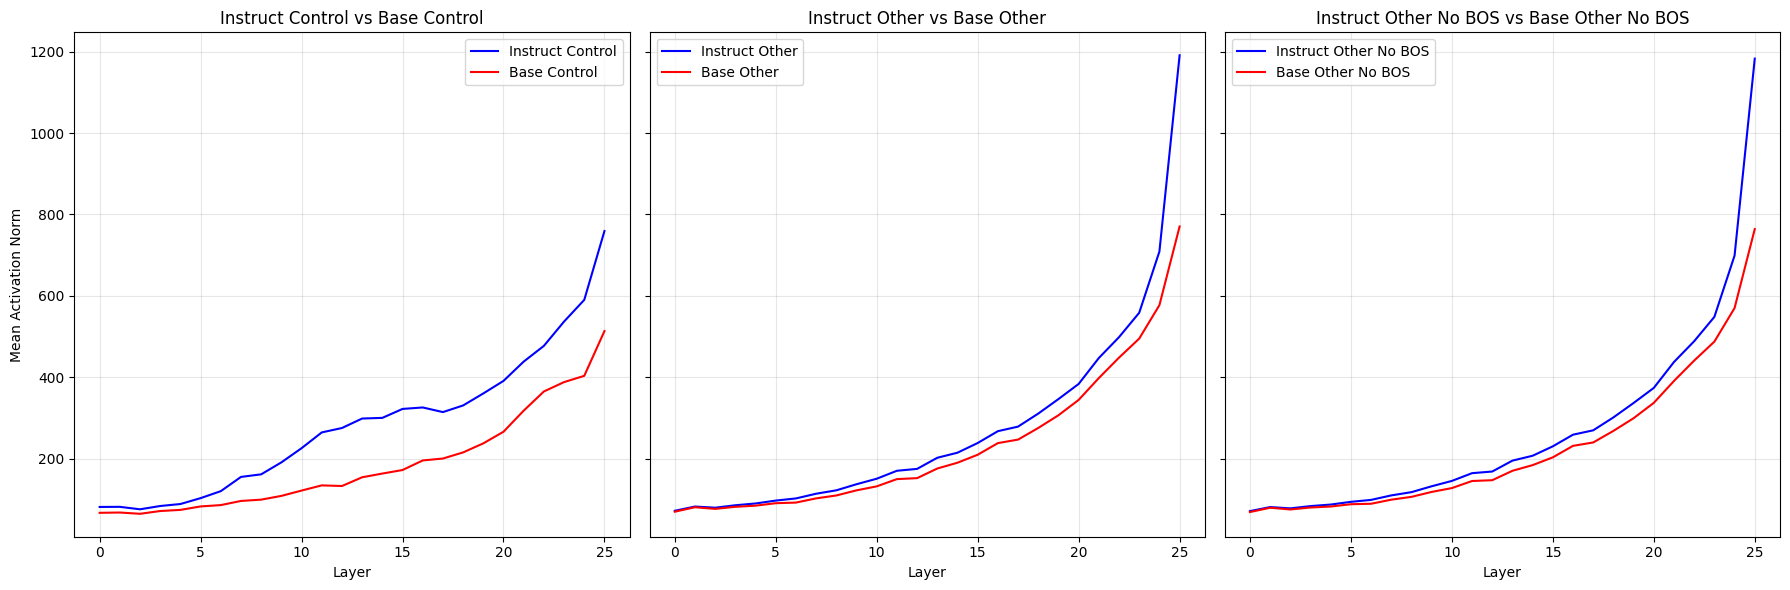

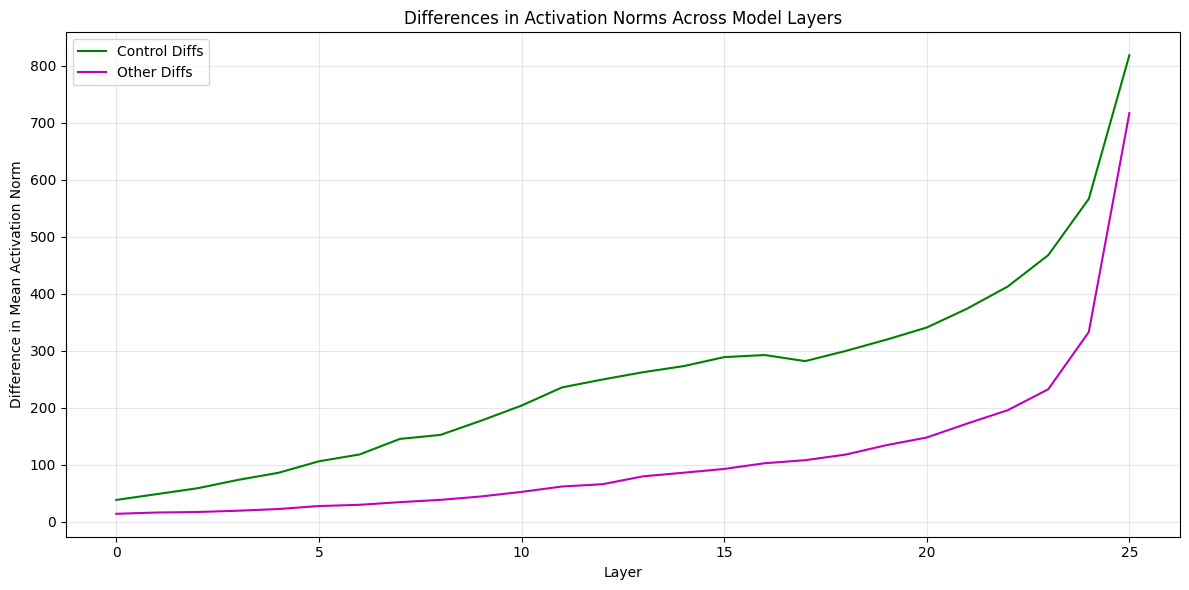

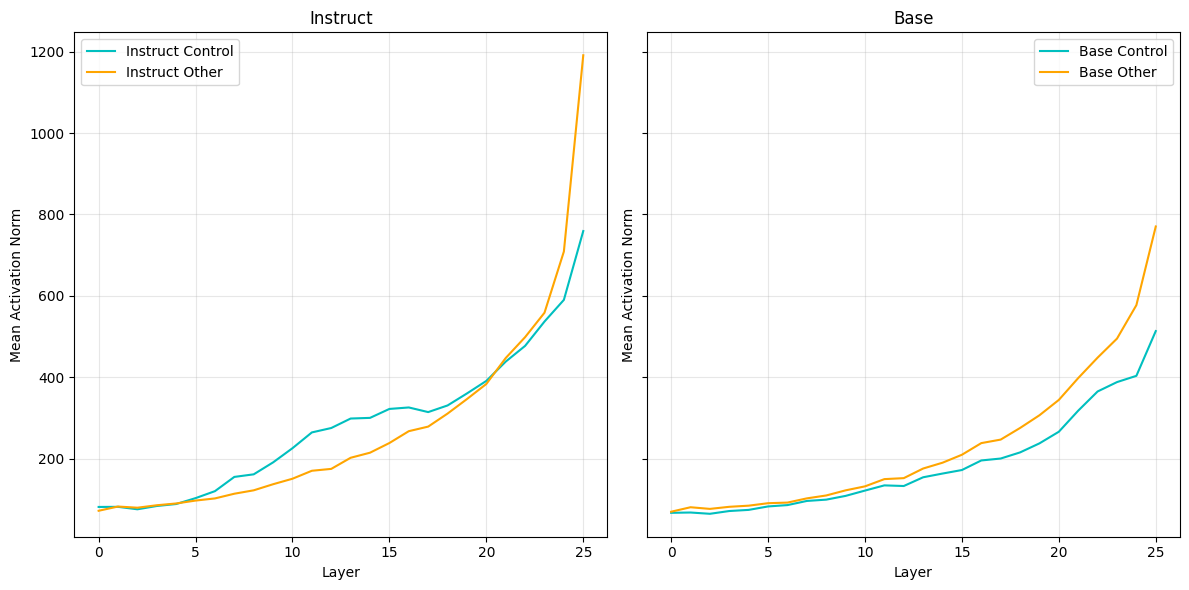

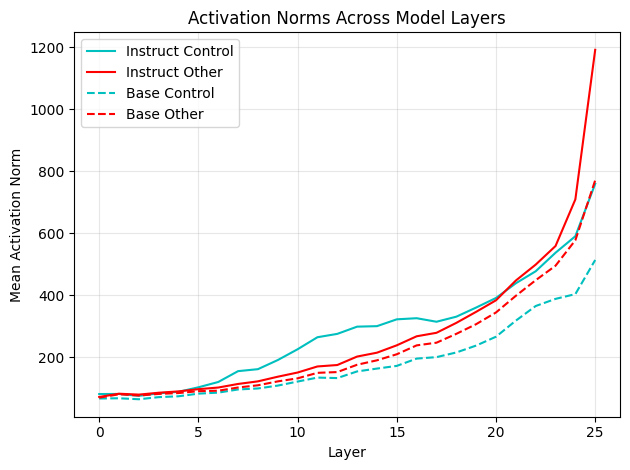

In [9]:
import matplotlib.pyplot as plt
import numpy as np
# Extract means for plotting
layers = list(range(num_layers))
it_control_means = [results[i]["it"]["control"].compute() for i in layers]
it_other_means = [results[i]["it"]["other"].compute() for i in layers]
it_other_no_bos_means = [results[i]["it"]["other_no_bos"].compute() for i in layers]
base_control_means = [results[i]["base"]["control"].compute() for i in layers]
base_other_means = [results[i]["base"]["other"].compute() for i in layers]
base_other_no_bos_means = [results[i]["base"]["other_no_bos"].compute() for i in layers]

# Create figure and axes for 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot lines for Instruct Control
axs[0].plot(layers, it_control_means, 'b-', label='Instruct Control')
axs[0].plot(layers, base_control_means, 'r-', label='Base Control')
axs[0].set_title('Instruct Control vs Base Control')
axs[0].set_xlabel('Layer')
axs[0].set_ylabel('Mean Activation Norm')
axs[0].grid(True, alpha=0.3)
axs[0].legend()

# Plot lines for Instruct Other
axs[1].plot(layers, it_other_means, 'b', label='Instruct Other')
axs[1].plot(layers, base_other_means, 'r', label='Base Other')
axs[1].set_title('Instruct Other vs Base Other')
axs[1].set_xlabel('Layer')
axs[1].grid(True, alpha=0.3)
axs[1].legend()

# Plot lines for Instruct Other No BOS
axs[2].plot(layers, it_other_no_bos_means, 'b', label='Instruct Other No BOS')
axs[2].plot(layers, base_other_no_bos_means, 'r', label='Base Other No BOS')
axs[2].set_title('Instruct Other No BOS vs Base Other No BOS')
axs[2].set_xlabel('Layer')
axs[2].grid(True, alpha=0.3)
axs[2].legend()

# Show plot
plt.tight_layout()
plt.show()

# Plot diffs
# Calculate the differences between means
control_diffs = [results[i]["diff"]["control"].compute() for i in layers]
other_diffs = [results[i]["diff"]["other"].compute() for i in layers]

# Plot the differences
plt.figure(figsize=(12, 6))
plt.plot(layers, control_diffs, 'g', label='Control Diffs')
plt.plot(layers, other_diffs, 'm', label='Other Diffs')

# Customize plot
plt.xlabel('Layer')
plt.ylabel('Difference in Mean Activation Norm')
plt.title('Differences in Activation Norms Across Model Layers')
plt.legend()
plt.grid(True, alpha=0.3)

# Show plot
plt.tight_layout()
plt.show()

# plot grouped by model rather than layer
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axs[0].plot(layers, it_control_means, 'c', label='Instruct Control')
axs[0].plot(layers, it_other_means, 'orange', label='Instruct Other')
axs[1].plot(layers, base_control_means, 'c', label='Base Control')
axs[1].plot(layers, base_other_means, 'orange', label='Base Other')
axs[0].set_title('Instruct')
axs[1].set_title('Base')
axs[0].set_xlabel('Layer')
axs[1].set_xlabel('Layer')
axs[0].set_ylabel('Mean Activation Norm')
axs[1].set_ylabel('Mean Activation Norm')
axs[0].legend()
axs[1].legend()
axs[0].grid(True, alpha=0.3)
axs[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.plot(layers, it_control_means, 'c', label='Instruct Control')
plt.plot(layers, it_other_means, 'r', label='Instruct Other')
plt.plot(layers, base_control_means, 'c--', label='Base Control')
plt.plot(layers, base_other_means, 'r--', label='Base Other')
plt.xlabel('Layer')
plt.ylabel('Mean Activation Norm')
plt.title('Activation Norms Across Model Layers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:

# print the last tokens and control mask with color for control mask == 1
index = th.randint(0, len(batch["input_ids"]), (1,)).item()
for i in range(len(batch["input_ids"][index])):
    tok = it_model.tokenizer.decode(batch["input_ids"][index][i])
    if tok == "\n":
        tok = "\\n\n"
    if control_mask[index][i] == 1:
        print(f"\033[91m{tok}\033[0m", end="")
    else:
        print(tok, end="")



<bos><start_of_turn>user\n
Do you know individualistic value system? Tell me the characteristics of a person with individualistic value system.<end_of_turn>\n
<start_of_turn>model\n
Individualistic value system is the belief that an individual should be free to make choices without interference from society or the government. Characteristics of a person with individualistic value system are as follows:\n
1. Autonomy: Individuals are free to make their own choices without interference from others.\n
2. Equality of opportunity: Individuals are entitled to equal chances to achieve their goals.\n
3. Personal responsibility: Individuals are responsible for the consequences of their own actions.\n
4. Flexibility: Individuals are free to change their own values, ideals, and beliefs.\n
5. Personal success: Individuals are free to pursue their own definition of success.\n
6. Spirituality: Individuals are free to pursue their own spiritual beliefs and faith.\n
7. Self-sufficiency: Individuals ar

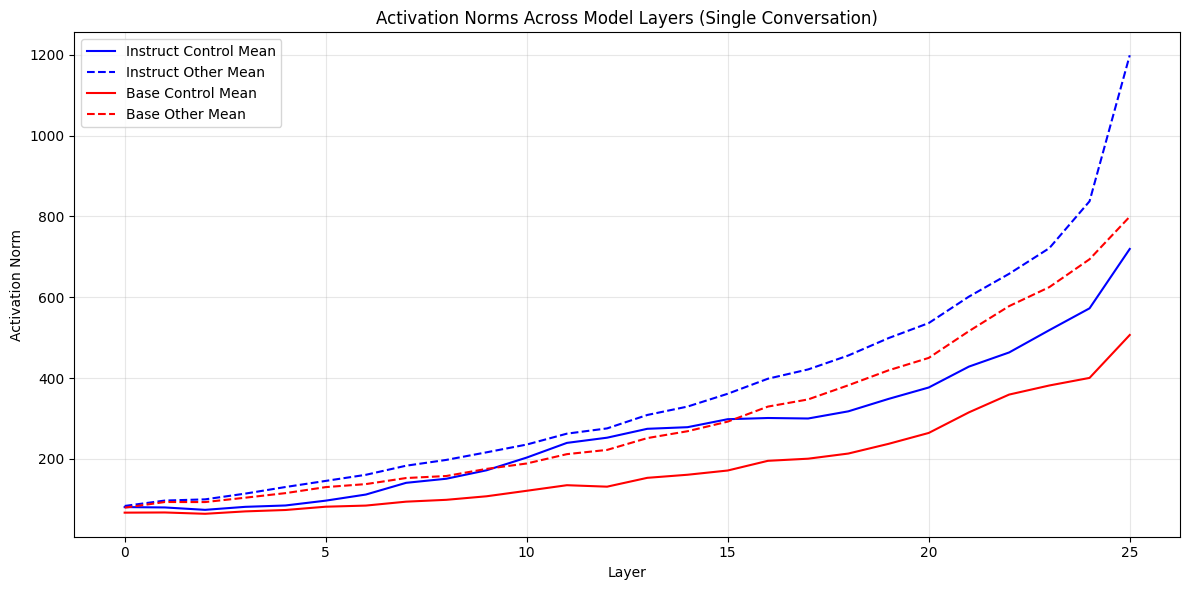

<bos><start_of_turn>user\n
Hello, how are you?<end_of_turn>\n
<start_of_turn>model\n
I am fine, thank you!<end_of_turn>\n
<start_of_turn>user\n
What is your name?<end_of_turn>\n
<start_of_turn>model\n
I am a chatbot.<end_of_turn>\n


In [29]:

import torch as th
from tqdm.auto import trange
from collections import defaultdict
import matplotlib.pyplot as plt
from nnterp.nnsight_utils import get_num_layers, get_layer_output
from utils import create_control_mask

# Disable gradients
th.set_grad_enabled(False)

# Simple example conversation
conv = [
    {"role": "user", "content": "Hello, how are you?"},
    {"role": "assistant", "content": "I am fine, thank you!"},
    {"role": "user", "content": "What is your name?"},
    {"role": "assistant", "content": "I am a chatbot."},
]

num_layers = get_num_layers(it_model)
results = [defaultdict(lambda: defaultdict(list)) for _ in range(num_layers)]

# Prepare batch
batch = it_model.tokenizer.apply_chat_template(
    [conv]* 2,
    return_dict=True,
    return_assistant_tokens_mask=True,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=1024,
)

# Create masks
control_mask = create_control_mask(batch, eot_token=eot_token).bool()
other_mask = ~control_mask & batch["attention_mask"].bool()

# Run computation for instruction-tuned model
with it_model.trace(batch):
    for i in range(num_layers):
        it_norms = get_layer_output(it_model, i).norm(dim=-1).save()
        results[i]["it"]["control"].append(it_norms[control_mask].save())
        results[i]["it"]["other"].append(it_norms[other_mask].save())
# Run computation for base model
with base_model.trace(batch):
    for i in range(num_layers):
        base_norms = get_layer_output(base_model, i).norm(dim=-1).save()
        results[i]["base"]["control"].append(base_norms[control_mask].save())
        results[i]["base"]["other"].append(base_norms[other_mask].save())

# Extract means, mins, and maxes for plotting
layers = list(range(num_layers))
it_control_means = [results[i]["it"]["control"][0].mean().item() for i in layers]
it_other_means = [results[i]["it"]["other"][0].mean().item() for i in layers]
base_control_means = [results[i]["base"]["control"][0].mean().item() for i in layers]
base_other_means = [results[i]["base"]["other"][0].mean().item() for i in layers]

it_control_mins = [results[i]["it"]["control"][0].min().item() for i in layers]
it_other_mins = [results[i]["it"]["other"][0].min().item() for i in layers]
base_control_mins = [results[i]["base"]["control"][0].min().item() for i in layers]
base_other_mins = [results[i]["base"]["other"][0].min().item() for i in layers]

it_control_maxes = [results[i]["it"]["control"][0].max().item() for i in layers]
it_other_maxes = [results[i]["it"]["other"][0].max().item() for i in layers]
base_control_maxes = [results[i]["base"]["control"][0].max().item() for i in layers]
base_other_maxes = [results[i]["base"]["other"][0].max().item() for i in layers]

# Create plot
plt.figure(figsize=(12, 6))
plt.plot(layers, it_control_means, 'b-', label='Instruct Control Mean')
plt.plot(layers, it_other_means, 'b--', label='Instruct Other Mean')
plt.plot(layers, base_control_means, 'r-', label='Base Control Mean')
plt.plot(layers, base_other_means, 'r--', label='Base Other Mean')

# plt.plot(layers, it_control_mins, 'b:', label='Instruct Control Min')
# plt.plot(layers, it_other_mins, 'b-.', label='Instruct Other Min')
# plt.plot(layers, base_control_mins, 'r:', label='Base Control Min')
# plt.plot(layers, base_other_mins, 'r-.', label='Base Other Min')

# plt.plot(layers, it_control_maxes, 'g-', label='Instruct Control Max')
# plt.plot(layers, it_other_maxes, 'g--', label='Instruct Other Max')
# plt.plot(layers, base_control_maxes, 'm-', label='Base Control Max')
# plt.plot(layers, base_other_maxes, 'm--', label='Base Other Max')

plt.xlabel('Layer')
plt.ylabel('Activation Norm')
plt.title('Activation Norms Across Model Layers (Single Conversation)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print the conversation with control tokens highlighted
for tok, mask in zip(batch["input_ids"][0], control_mask[0]):
    tok = it_model.tokenizer.decode(tok)
    if tok == "\n":
        tok = "\\n\n"
    if mask == 1:
        print(f"\033[91m{tok}\033[0m", end="")
    else:
        print(tok, end="")
# create html object that  

In [21]:
from utils import activation_visualization
from IPython.display import HTML

HTML(activation_visualization(it_model.tokenizer.convert_ids_to_tokens(batch["input_ids"][0]), it_norms[0], it_model.tokenizer))

## KL with control mask exp